# Setup

In [1]:
import numpy as np
import math
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt

Sample data (canonical m=2 example from SKPrime):

In [2]:
dv = np.array([-0.2517+0.3129j, 0.2307-0.4667j])
qv = np.array([0.2377, 0.1557])
m = dv.size

Some useful constructs.

In [3]:
def polyval(c, z):
    "Polynomial evaluation using Horner's method."
    
    p = np.zeros(z.shape, dtype=z.dtype)
    for a in c:
        p = p*z + a
        
    return p

In [4]:
i2pi = 2.0j*math.pi

def boundaryPoints(N, rot=0.):
    "Generate N points on each boundary circle, including unit."
    
    m = dv.size
    circ = np.exp(i2pi*np.arange(N, dtype=np.double)/N + rot)
    z = np.empty((m+1, N), dtype=np.complex_)
    z[0,:] = circ
    for d, q, j in zip(dv, qv, range(m)):
        z[j+1,:] = d + q*circ
        
    return z

In [5]:
def rinterp(z, a):
    "Real interpolant on boundary circles."
    "Expect each row of z on separate boundary."
    
    w = np.empty(z.shape, dtype=np.double)
    a[:,0] /= 2.
    for j, d, q in zip(range(m+1), np.hstack([0., dv]), np.hstack([1., qv])):
        w[j,:] = 2.*polyval(np.flip(a[j,:]), (zt[j,:] - d)/q).real
        
    return w

In [6]:
def cinterp(z, c):
    "Complex interpolant on boundary circles."
    "Expect each row of z on separate boundary."
    
    M = c[0,:].size
    kend = M//2 + 1
    w = np.empty(z.shape, dtype=np.complex_)
    for j, d, q in zip(range(m+1), np.hstack([0., dv]), np.hstack([1., qv])):
        w[j,:] = (c[j,0] 
                  + polyval( np.hstack([np.flip(c[j,1:kend]), np.zeros((1,))]), (z[j,:] - d)/q )
                  + polyval( np.hstack([c[j,kend:], np.zeros((1,))]), q/(z[j,:] - d) )
                 )
        
    return w

In [7]:
def afunction(z):
    "Put a pole in each circle center."
    
    w = z**2
#     w = np.zeros(z.shape, z.dtype)
#     for d, q in zip(dv, qv):
#         w += 1./(z - d)
        
    return w

# real and imaginary parts
g = lambda z: afunction(z).real
h = lambda z: afunction(z).imag

In [8]:
def afunctionD(z):
    "First derivative of afunction(z)."
    
    w = 2.*z
#     w = np.zeros(z.shape, z.dtype)
#     for d, q in zip(dv, qv):
#         zmd = z - d
#         w += -1./zmd/zmd
        
    return w

# Complex interpolant

Sample $M$ points on each boundary.

In [9]:
M = 64
zb = boundaryPoints(M)

In [10]:
c = np.empty(zb.shape, dtype=np.complex_)
for j in range(m+1):
    c[j,:] = fft(afunction(zb[j,:]))/M

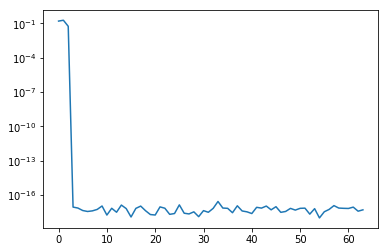

In [11]:
plt.plot(abs(c[1,:]))
plt.yscale('log')

Pick points not in samples and compare interpolate with actual.

In [12]:
zt = boundaryPoints(M, 1j/M/2.)

In [13]:
wt = cinterp(zt, c)
np.max(abs(afunction(zt) - wt), axis=1)

array([1.26584901e-15, 1.69399989e-16, 1.75541673e-16])

# Real interpolant

Create real-valued interpolation coefficients ($a_k$) for real part of sample funciton via FFT. Only need to store 1/2 of the coefficients since $a_k = \overline{a_{-k}}$.

In [14]:
a = np.empty(zb.shape, dtype=np.complex_)
for j in range(m+1):
    a[j,:] = fft(g(zb[j,:]))/M
a = a[:,0:M//2+1]

Compute real interpolant by row; check values with source function.

In [15]:
gt = rinterp(zt, a)
print(np.max(abs(g(zt) - gt), axis=1))

[9.99200722e-16 1.66533454e-16 1.66533454e-16]


Look at relationship $a_k = {1\over2} \{ c_k + \overline{c_{-k}} \}$

In [16]:
ac = np.empty(a.shape, dtype=np.complex_)
ac[:,0] = c[:,0].real/2.
kend = M//2 + 1
if (M % 2) == 0:
    # There is a nyquist component.
    ac[:,1:kend-1] = (c[:,1:kend-1] + np.fliplr(c[:,kend:]).conj())/2.
    ac[:,kend-1] = c[:,kend-1].real/2.
else:
    # There is not.
    ac[:,1:kend] = (c[:,kend] + np.fliplr(c[kend:]).conj())/2.

In [17]:
print(np.max(abs(a - ac), axis=1))

[3.96274779e-17 1.38524936e-17 1.38777878e-17]


Now consider $b_k = \frac{1}{2j} \{ c_k - \overline{c_{-k}} \}$.

In [18]:
b = np.empty(zb.shape, dtype=np.complex_)
for j in range(m+1):
    b[j,:] = fft(h(zb[j,:]))/M
b = b[:,0:M//2+1]

In [19]:
ht = rinterp(zt, b)
print(np.max(abs(h(zt) - ht), axis=1))

[1.11022302e-15 1.66533454e-16 1.11022302e-16]


In [20]:
bc = np.empty(b.shape, dtype=np.complex_)
bc[:,0] = c[:,0].imag/2.
if (M % 2) == 0:
    bc[:,1:kend-1] = (c[:,1:kend-1] - np.fliplr(c[:,kend:]).conj())/2.j
    bc[:,kend-1] = c[:,kend-1].imag/2.
else:
    bc[:,1:kend] = (c[:,kend] - np.fliplr(c[kend:]).conj())/2.j

In [21]:
print(np.max(abs(b - bc), axis=1))

[5.41707838e-17 1.38777878e-17 1.96297363e-17]


# Derivatives

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 -32 -31 -30
 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12
 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
(65,)
[3.999708   1.54831477 1.23237544]


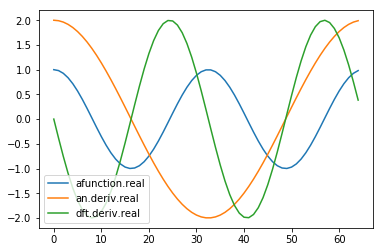

In [30]:
M = 65
N = M//2

zb = boundaryPoints(M)
w = afunction(zb)
wp = afunctionD(zb)

if M % 2 == 0:
    k = np.hstack([np.arange(N), np.array([0]), np.arange(-N+1, 0)])
else:
    k = np.hstack([np.arange(N+1), np.arange(-N, 0)])
print(k)
print(k.shape)

wtf = np.fft.ifft(1.j*k*np.fft.fft(afunction(zb)))
print(np.max(abs(wtf - afunctionD(zb)), axis=1))

plt.plot(w[0,:].real, label='afunction.real')
# plt.plot(w[0,:].imag, label='afunction.imag')
plt.plot(wp[0,:].real, label='an.deriv.real')
plt.plot(wtf[0,:].real, label='dft.deriv.real')
plt.legend(loc='lower left')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 -32 -31 -30
 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12
 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1]
(65,)
(65,)
3.520147021340204


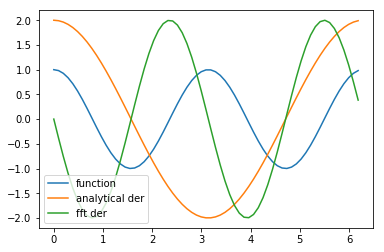

In [23]:
import numpy as np
import matplotlib.pyplot as plt

N = 65 #number of points
N2 = N//2
L = 2 * np.pi #interval of data

x = np.arange(0.0, L, L/float(N)) #this does not include the endpoint

y = afunction(np.exp(1j*x)).real # np.sin(x)
dy_analytical = afunctionD(np.exp(1j*x)).real # np.cos(x)

'''
http://sci.tech-archive.net/Archive/sci.math/2008-05/msg00401.html

you can use fft to calculate derivatives!
'''

if N % 2 == 0:
    k = np.hstack([np.arange(N2), np.array([0]), np.arange(-N2+1, 0)])
#     k = np.asarray(range(0, N / 2) + [0] + range(-N / 2 + 1,0))
else:
    k = np.hstack([np.arange(N2+1), np.arange(-N2, 0)])
#     k = np.asarray(range(0,(N - 1) / 2) + [0] + range(-(N - 1) / 2, 0))
print(k)
print(k.shape)
print(y.shape)
# k = k * 2 * np.pi / L
# k *= 2 * np.pi / L

fd = np.real(np.fft.ifft(1.0j * k * np.fft.fft(y)))
print(max(abs(fd - dy_analytical)))

plt.plot(x, y, label='function')
plt.plot(x,dy_analytical,label='analytical der')
plt.plot(x,fd,label='fft der')
plt.legend(loc='lower left')

# plt.savefig('images/fft-der.png')
plt.show()